In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.optimize as optim
from scipy import stats
import cvxpy as cp
from tqdm import tqdm
import json
import os
import sys
import seaborn as sns
import pandas as pd
sys.path.append('..')

from src.samplers.importance_sampler import *
from src.data_utils import grid_data
from src.samplers.utils import check_feasibility_out_of_sample
from src.samplers import preprocessing as pre
from src.data_utils import synthetic as synth
from src.solvers import scenario_approx as SA
from src.solvers import utils as SU
from src.solvers import analytical_approx as AA

In [2]:

#Gamma, Beta = synth.regular_polyhedron(10, 6)
grid_name = 'grid57'

Gamma, Beta, gens, cost_coeffs, cost_correction_term, cost_dc_opf = grid_data.get_linear_constraints(grid_name, check_pp_vs_new_form=True)
x0 = gens[1:]
print(Gamma, Beta)
mu = np.zeros(len(gens) - 1)
Sigma = np.eye(len(gens) - 1) * 0.01 
# making matrix psd
Sigma = Sigma.dot(Sigma.T)
#A = Gamma
Gamma, Beta, A = pre.standartize(Gamma, Beta, mu, Sigma)
print(len(Gamma), len(Beta))
J = Gamma.shape[0]
print(len(A))
c = cost_coeffs

/Users/aleks/opt/anaconda3/envs/py39_scenario/lib/python3.9/site-packages/pandapower/pypower/opf_model.py:494: ComplexWarning: Casting complex values to real discards the imaginary part
  Ai[:, j1:jN] = Ak[:, k1:kN].todense()
/Users/aleks/opt/anaconda3/envs/py39_scenario/lib/python3.9/site-packages/pandapower/pypower/opf_model.py:498: ComplexWarning: Casting complex values to real discards the imaginary part
  l[i1:iN] = self.lin["data"]["l"][name]
/Users/aleks/opt/anaconda3/envs/py39_scenario/lib/python3.9/site-packages/pandapower/pypower/opf_model.py:499: ComplexWarning: Casting complex values to real discards the imaginary part
  u[i1:iN] = self.lin["data"]["u"][name]


sol from pandapower proximity: 2.9475236766662003
cost from this method: 25015.999999993986
cost from pandapower: 25016.000000022632
[[-0.87164579 -0.48199909 -0.38161513 -0.31601679 -0.28137114 -0.20738249]
 [ 0.12835421 -0.48199909 -0.38161513 -0.31601679 -0.28137114 -0.20738249]
 [ 0.02465378  0.0994956  -0.55671987 -0.33631243 -0.22287363 -0.10269846]
 ...
 [-0.         -0.         -0.         -1.         -0.         -0.        ]
 [-0.         -0.         -0.         -0.         -1.         -0.        ]
 [-0.         -0.         -0.         -0.         -0.         -1.        ]] [ 9.57632433e+01  9.57932433e+01  9.66236478e+01  9.80977482e+01
  9.78608204e+01  9.83511183e+01  9.84874504e+01  9.96716477e+01
  9.92204021e+01  9.97437718e+01  9.92869659e+01  9.98292385e+01
  1.00215889e+02  1.00806960e+02  9.47639016e+01  9.68286338e+01
  9.66862213e+01  9.85795955e+01  9.82277482e+01  9.86841974e+01
  9.93775708e+01  9.99282491e+01  9.97993919e+01  1.00741366e+02
  1.00893779e+02  1.0

In [3]:
eta = 0.05

# Union bound (Boole's approximation)
Assume the system is standartized $\left(\chi \sim \mathcal{N}(0, I_n), ~ \| a_i \|_2 = 1\right)$
$$
\begin{aligned}
\mathbb{P} \Bigg\{ \forall ~ i ~ \gamma_i^\top x + &a_i^\top \chi \leq \beta_i \Bigg\} \geq 1 - \eta \\
&\Updownarrow \\
\mathbb{P} \Bigg\{ \bigcup_{i=1}^J ~ \gamma_i^\top x + &a_i^\top \chi > \beta_i \Bigg\} \leq  \eta
\end{aligned}
$$
Note that
$$
\mathbb{P} \Bigg\{ \bigcup_{i=1}^J ~ \gamma_i^\top x + a_i^\top \chi > \beta_i \Bigg\} \leq \sum_{i=1}^J \mathbb{P} \Bigg\{  \gamma_i^\top x + a_i^\top \chi > \beta_i \Bigg\}
$$
Due to the semi-additivity of measure $\mathbb{P}$. Thus, ensuring R.H.S. to be less thatn $\eta$, we ensure original probability to be less than $\eta$ -- conservative approximation.

In [33]:
# Standartization in prior must be conducted
res_boole = AA.inner_polyhedral(eta, Gamma, Beta, x0=x0, c = c)
boole_prob = check_feasibility_out_of_sample(res_boole.x, Gamma, Beta, A, 1000000)
print(boole_prob)

/Users/aleks/opt/anaconda3/envs/py39_scenario/lib/python3.9/site-packages/scipy/optimize/_minimize.py:542: RuntimeWarning: Method Nelder-Mead does not use gradient information (jac).
  warn('Method %s does not use gradient information (jac).' % method,


Optimiziation Succeeded: False
0.5


In [34]:
Gamma.dot(res_boole.x) - Beta
AA.inner_polyhedral_constraint(res_boole.x, Gamma, Beta, eta)

1.4499939138913338

# Solve several scenario approximations

In [4]:
# Store sigma and mu, next, the solutions for approximation will be pushed
results = {"Sigma": [[float(v) for v in row] for row in Sigma], 
           "mu": [float(v) for v in mu]}
N0 = 10
ks = list(range(1, 30))[::5]
L = 100
optimize_samples = True
np.random.seed(112)

In [11]:
#parallel and discard useless planes and samples
x0_dict = {"SAIMIN": x0, "SCSA": x0, "SCSA_no_O": x0}
for k in tqdm(ks):
    N = N0 * k
    for l in range(L):
        res = SU.solve_approximations(Gamma=Gamma, Beta=Beta, A=A, N=N, c=c, eta=eta, optimize_samples=optimize_samples, x0=x0_dict)
        
        for k in x0_dict.keys():
            x0_dict[k] = res[k][0]
        try:
            results[N].append(res)
        except KeyError:
            results[N] = []
            results[N].append(res)

  0%|          | 0/6 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Unpack results and plot them

In [5]:
save_dir = os.path.join("..", "saves", grid_name)
json_file = os.path.join("N_" + str(N0 * ks[-1]) + ".json")

In [6]:
os.path.join(save_dir, json_file)

'../saves/grid57/N_260.json'

In [7]:
def map_names(results, new_names=['SAO-ScenarioApproxWithO', 'SA-ScenarioApprox', 'SAIS-ScenarioApproxImportanceSampling']):
    for r in results.keys():
        if r not in ["Sigma", "mu"]:
            for l in results[r]:
                keys = list(l.keys())
                for i in range(len(keys)):
                    l[new_names[i]] = l.pop(keys[i])
    return results

In [8]:
# try:
#     with open(os.path.join(save_dir, json_file), 'w') as fp:
#         json.dump(results, fp, indent=4)
# except FileNotFoundError:
#     os.makedirs(save_dir)
#     with open(os.path.join(save_dir, json_file), 'w') as fp:
#         json.dump(results, fp, indent=4)

In [9]:
# # load if necessary
with open(os.path.join(save_dir, json_file), 'r') as fp:
    results = json.load(fp)

In [10]:
results = map_names(results, new_names=['SAO-ScenarioApproxWithO', 'SA-ScenarioApprox', 'SAIS-ScenarioApproxImportanceSampling'])

Text(0, 0.5, 'Objective')

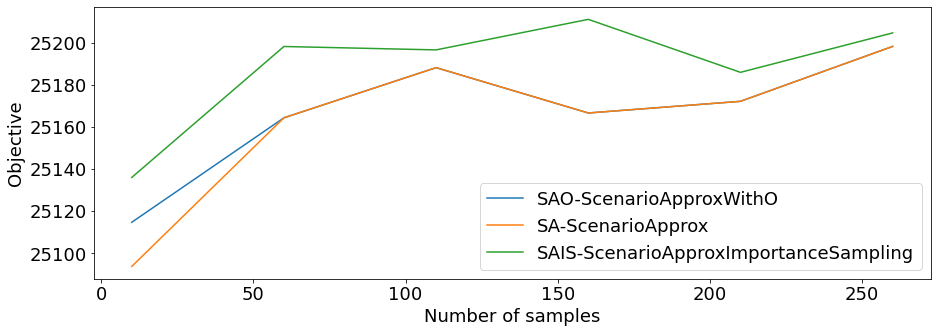

In [42]:
plt.figure(figsize=(15, 5))
def unpack_results(results, c, k, cost_correction_term):
    try:
        names = list(results[N0][k].keys())
    except KeyError:
        names = list(results[str(N0)][k].keys())
    fns = []
    xs = []
    for r in results.keys():
        if r not in ["Sigma", "mu"]:
            for v in results[r][k].values():
                try:
                    xs.append(v[0])
                    fns.append(np.dot(v[0], c) + cost_correction_term)
                except ValueError:
                    fns.append(np.nan)
    fns = np.array(fns).reshape(-1, len(names))
    xs = np.array(xs).reshape(-1, len(names), A.shape[1])
    return fns, xs, names
fns, xs, names = unpack_results(results=results, c=c, k=ks[0], cost_correction_term=cost_correction_term)
for i in range(fns.shape[1]):
    plt.plot(np.array(ks) * N0, fns[:, i], label=names[i])

#plt.hlines(y = [res_boole.fun], xmin = 0, xmax = ks[-1] * N0, label='Boole', color='black', linestyle='dotted')
plt.legend()
plt.xlabel("Number of samples")
plt.ylabel("Objective")

# Out of sample validation

In [43]:
boole_prob = check_feasibility_out_of_sample(res_boole.x, Gamma, Beta, A, 100000)
scenarios_probs = np.array([np.apply_along_axis(arr=xs[:, i, :], func1d=lambda x: check_feasibility_out_of_sample(x, Gamma, Beta, A, 100000), axis=1) for i in range(len(names))])

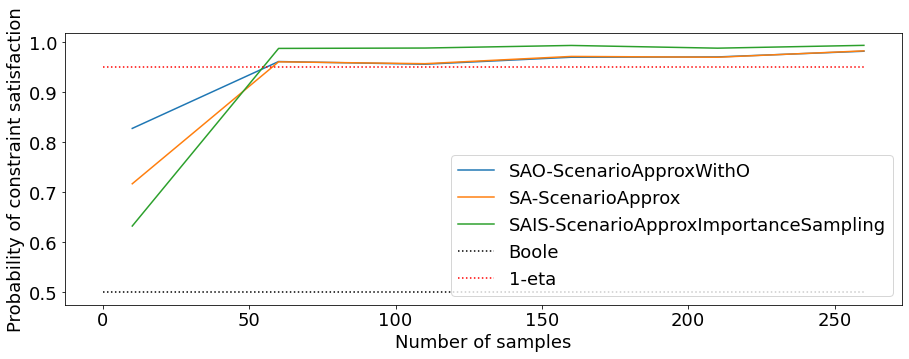

In [44]:
plt.figure(figsize=(15, 5))

for i in range(scenarios_probs.shape[0]):
    plt.plot(np.array(ks) * N0, scenarios_probs[i,:], label=names[i])

plt.hlines(y = [boole_prob], xmin = 0, xmax = ks[-1] * N0, label='Boole', color='black', linestyle='dotted')
plt.hlines(y = [1-eta], xmin = 0, xmax = ks[-1] * N0, label='1-eta', color='red', linestyle='dotted')
plt.legend()
#plt.yscale('log')
#plt.ylim((1-eta-1e-2, 1 + 1e-4))
plt.xlabel("Number of samples")
plt.ylabel("Probability of constraint satisfaction")
plt.show()

# Plot results of multiple simulations
> 1. Estimates for probability of a solution of approximation to be feasible for original problem ($\beta$)
> 2. Box plots for estimates of probability of satisfying constraints

In [45]:
scenario_prob_estimate = np.zeros((len(names), len(ks)))
scenario_probs_several_starts = []
for k in tqdm(range(L)):
    _, xs, names = unpack_results(results=results, c=cost_coeffs, cost_correction_term=cost_correction_term, k=k)
    #boole_prob = check_feasibility_out_of_sample(res_boole.x, Gamma, Beta, A, 100000)
    scenarios_probs = np.array([np.apply_along_axis(arr=xs[:, i, :], func1d=lambda x: check_feasibility_out_of_sample(x, Gamma, Beta, A, 100000), axis=1) for i in range(3)])
    scenario_prob_estimate += (scenarios_probs - eta >= 0.)
    scenario_probs_several_starts.append(scenarios_probs)
scenario_prob_esimate = scenario_prob_estimate / L
scenario_probs_several_starts = np.array(np.stack(scenario_probs_several_starts))

  0%|          | 0/100 [00:00<?, ?it/s]

In [46]:
pd_boxplot = pd.DataFrame({"N": [], "Method": [], r"$(\hat{\mathbb{P}}_N)_l$": []})
for method_idx in range(scenario_probs_several_starts.shape[1]):
    data = scenario_probs_several_starts[:, method_idx, :]
    pd_boxplot_tmp = pd.DataFrame({"N": [], "Method": [], r"$(\hat{\mathbb{P}}_N)_l$": []})
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            pd_boxplot_tmp = pd.concat([pd_boxplot_tmp, pd.DataFrame({"N": [ks[j] * N0], "Method": [names[method_idx]], r"$(\hat{\mathbb{P}}_N)_l$": [data[i, j]]})], ignore_index=True)
    pd_boxplot = pd.concat([pd_boxplot, pd_boxplot_tmp])

In [47]:
#save to csv
pandas_name = 'multistarts.csv'
pd_boxplot.to_csv(os.path.join(save_dir, pandas_name))

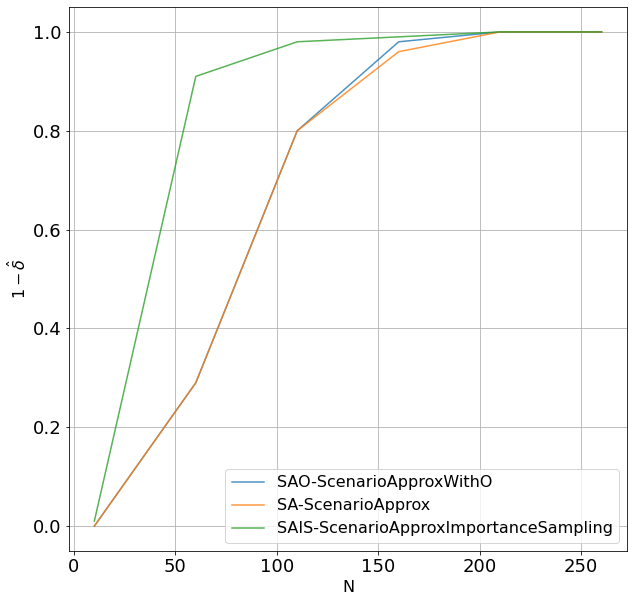

In [48]:
plt.figure(figsize=(10, 10))
fsize = 16
figure_path_1_beta = os.path.join(save_dir, "figures", "1_beta_N_" + str(N0 * ks[-1]) + ".png")
for i in range(len(names)):
    pdSeries_tmp = (pd_boxplot.loc[(pd_boxplot["Method"] == names[i]) & (pd_boxplot["N"] > 2)])
    #pdSeries_tmp.loc[:, "Prob_est - 1-eta"] = pdSeries_tmp["Prob_est - 1-eta"].apply(lambda x: 1.0 if x >= 0 else 0.0)
    pdSeries_tmp.loc[:, r"$(\hat{\mathbb{P}}_N)_l$"] = (pdSeries_tmp[r"$(\hat{\mathbb{P}}_N)_l$"] > 1-eta).values
    pdSeries_tmp = pdSeries_tmp.groupby("N").mean()
    x_plot = pdSeries_tmp.index
    y_plot = pdSeries_tmp[r"$(\hat{\mathbb{P}}_N)_l$"].values
    plt.plot(x_plot, y_plot, label=names[i], alpha=0.8)
    #plt.plot(np.array(ks)[1:] * N0, scenario_prob_esimate[i, 1:], label=names[i])
plt.xlabel("N", fontsize=fsize)
plt.ylabel(r"$1 - \hat{\delta}$", fontsize=fsize)
plt.grid()
plt.legend(prop={'size': fsize})
try:
    plt.savefig(figure_path_1_beta)
    pass
except FileNotFoundError:
    os.makedirs(os.path.join(save_dir, "figures"))
    plt.savefig(figure_path_1_beta)

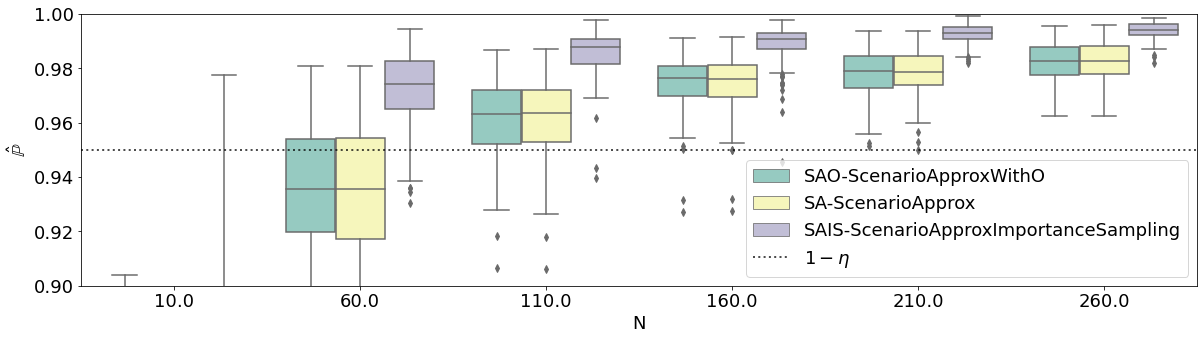

In [49]:
figure_path_box = os.path.join(save_dir, "figures", "boxplot_J_N_" + str(N0 * ks[-1]) + ".png")
plt.figure(figsize=(20, 5))
ax = sns.boxplot(x="N", y=r"$(\hat{\mathbb{P}}_N)_l$", hue="Method",
                 data=pd_boxplot[pd_boxplot["N"] > 6], palette="Set3")
ax.axhline(1-eta, 0, 1, label=r'$1 - \eta$', color='black', linewidth=2, alpha=0.7, linestyle='dotted')
plt.ylim((1 - 2 * eta, 1.))
plt.legend()
#plt.hlines(y = [1-eta], xmin = pd_boxplot["N"].min(), xmax = pd_boxplot["N"].max(), label=r'$1 - \eta$', color='black', linestyle='dotted')
#plt.grid()
try:
    plt.savefig(figure_path_box)
    pass
except FileNotFoundError:
    os.makedirs(os.path.join(save_dir, "figures"))
    plt.savefig(figure_path_box)
